In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import cv2
import numpy as np

In [0]:
# Function to convert image from greyscale to one hot (i.e. 4 channels)
def convertToOneHot(image):
    num_classes = 4
    shape = image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c]==0:
          encoded_image[r][c][0] = 1
        elif image[r][c]==85:
          encoded_image[r][c][1] = 1
        elif image[r][c]==170:
          encoded_image[r][c][2] = 1
        else:
          encoded_image[r][c][3] = 1
    return encoded_image

In [0]:
# Function to convert back from one hot image to greyscale
def convertFromOneHot(image):
    shape = image.shape[:2]
    encoded_image = np.zeros(shape, dtype=np.uint8)
    for r in range(len(image)):
      for c in range(len(image[0])):
        if image[r][c][0] == 1:
          encoded_image[r][c] = 0
        elif image[r][c][1] == 1:
          encoded_image[r][c] = 85
        elif image[r][c][2] == 1:
          encoded_image[r][c] = 170
        else:
          encoded_image[r][c] = 255
    return encoded_image

In [0]:
PATH = "/content/drive/My Drive/Breast Cancer Treatment/Numpy Arrays"

# Train set paitients: 230 239 232 242
TrainX_1 = np.load(PATH + '/PR IHC 239 Images.npy')
TrainY_1 = np.load(PATH + '/PR IHC 239 Masks.npy')
TrainX_2 = np.load(PATH + '/PR IHC 232 Images.npy')
TrainY_2 = np.load(PATH + '/PR IHC 232 Masks.npy')
TrainX_3 = np.load(PATH + '/PR IHC 242 Images.npy')
TrainY_3 = np.load(PATH + '/PR IHC 242 Masks.npy')
TrainX_4 = np.load(PATH + '/PR IHC 230 Images.npy')
TrainY_4 = np.load(PATH + '/PR IHC 230 Masks.npy')

# Test set paitients: 221 246
TestX_1 = np.load(PATH + '/PR IHC 221 Images.npy')
TestY_1 = np.load(PATH + '/PR IHC 221 Masks.npy')
TestX_2 = np.load(PATH + '/PR IHC 246 Images.npy')
TestY_2 = np.load(PATH + '/PR IHC 246 Masks.npy')


In [0]:
TrainX = np.concatenate((TrainX_1, TrainX_2, TrainX_3, TrainX_4), axis=0)
TrainGroundTruth = np.concatenate((TrainY_1, TrainY_2, TrainY_3, TrainY_4), axis=0)
TrainY = []

for img in TrainGroundTruth:
  encoded_img = convertToOneHot(img)
  TrainY.append(encoded_img)

TrainY = np.asarray(TrainY)

TestX = np.concatenate((TestX_1, TestX_2), axis=0)
TestGroundTruth = np.concatenate((TestY_1, TestY_2), axis=0)
TestY = []

for img in TestGroundTruth:
  encoded_img = convertToOneHot(img)
  TestY.append(encoded_img)

TestY = np.asarray(TestY)

ValidX = TrainX[2000:, : ]
ValidY = TrainY[2000:, : ]

TrainX = TrainX[0:2000, : ]
TrainY = TrainY[0:2000, : ]

print(TrainX.shape)
print(TrainY.shape)
print(TestX.shape)
print(TestY.shape)
print(ValidX.shape)
print(ValidY.shape)

(2000, 240, 240, 3)
(2000, 240, 240, 4)
(960, 240, 240, 3)
(960, 240, 240, 4)
(112, 240, 240, 3)
(112, 240, 240, 4)


In [0]:
TrainX = np.reshape(TrainX,(-1,240, 240,3))
TrainY = np.reshape(TrainY,(-1,240, 240,4))

TrainX = TrainX.astype('float32')/255

TestX = np.reshape(TestX,(-1,240, 240,3))
TestY = np.reshape(TestY,(-1,240, 240,4))

TestX = TestX.astype('float32')/255

ValidX = np.reshape(ValidX,(-1,240, 240,3))
ValidY = np.reshape(ValidY,(-1,240, 240,4))

ValidX = ValidX.astype('float32')/255

In [0]:
print(TrainX.shape)
print(TrainY.shape)

print(TestX.shape)
print(TestY.shape)

print(ValidX.shape)
print(ValidY.shape)

(2000, 240, 240, 3)
(2000, 240, 240, 4)
(960, 240, 240, 3)
(960, 240, 240, 4)
(112, 240, 240, 3)
(112, 240, 240, 4)


In [0]:
!pip install medpy
from keras.layers import *
import keras
from keras.models import Sequential
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
from medpy.metric import dc, precision, recall
from keras import Model

     |████████████████████████████████| 153kB 2.6MB/s 
     |████████████████████████████████| 42.5MB 72kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753455 sha256=0ceeb1cde54ff4307df124f958d438e7ab71b7b1ef20c367b43d01fa972e3e6b
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


Using TensorFlow backend.


In [0]:
def get_conv_block(input_layer,nFilters,size):
    conv1 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    bn1 = BatchNormalization()(conv1)
    conv2 = Conv2D(nFilters, size, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(bn1)
    bn2 = BatchNormalization()(conv2)
    return bn2
    
def get_model():    
    input_layer = Input(shape=(240,240,3))
    block1 = get_conv_block(input_layer,32,3)
    mp1 = MaxPooling2D(pool_size=(2, 2))(block1)
    dr1 = Dropout(0.1)(mp1)
    
    block2 = get_conv_block(dr1,64,3)
    mp2 = MaxPooling2D(pool_size=(2, 2))(block2)
    dr2 = Dropout(0.1)(mp2)
    
    block3 = get_conv_block(dr2,128,3)
    mp3 = MaxPooling2D(pool_size=(2, 2))(block3)
    dr3 = Dropout(0.1)(mp3)
    
    block4 = get_conv_block(dr3,256,3)
    mp4 = MaxPooling2D(pool_size=(2, 2))(block4)
    dr4 = Dropout(0.1)(mp4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(dr4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up1 = Conv2DTranspose(256,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(conv5)
    cat1 = concatenate([block4,up1])
    dr1 = Dropout(0.1)(cat1)
    block5 = get_conv_block(dr1,256,3)

    up2 = Conv2DTranspose(128,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block5)
    cat2 = concatenate([block3,up2])
    dr2 = Dropout(0.1)(cat2)
    block6 = get_conv_block(dr2,128,3)
    
    up3 = Conv2DTranspose(64,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block6)
    cat3 = concatenate([block2,up3])
    dr3 = Dropout(0.1)(cat3)
    block7 = get_conv_block(dr3,64,3)
    
    up4 = Conv2DTranspose(32,(3,3),strides =(2,2),activation='relu',padding='same',kernel_initializer = 'he_normal')(block7)
    cat4 = concatenate([block1,up4])
    dr4 = Dropout(0.1)(cat4)
    block8 = get_conv_block(dr4,64,3)

    conv10 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(block8)
    conv11 = Conv2D(4,(1,1), activation='softmax', padding = 'same')(conv10)

    model = Model(input_layer,conv11)
    return model

In [0]:
model = get_model()
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248      

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

In [0]:
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('Checkpoint.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
class_wt = [1,15,15,10]

In [0]:
from keras import backend as K      
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[dice_coef,'accuracy'])

In [0]:
num_epoch = 100;
MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
history = model.fit(TrainX, TrainY, epochs=num_epoch, validation_data=(ValidX, ValidY), shuffle=True,batch_size=32,callbacks=[es,mc],class_weight=class_wt)
model.save(MODELS_PATH + '/UNET_PR_30_12_19.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 112 samples
Epoch 1/100
2000/2000 [==============================] - 47s 24ms/step - loss: 0.3877 - dice_coef: 0.7738 - acc: 0.9143 - val_loss: 0.1330 - val_dice_coef: 0.9438 - val_acc: 0.9837

Epoch 00001: val_loss improved from inf to 0.13297, saving model to Checkpoint.h5
Epoch 2/100
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1603 - dice_coef: 0.9135 - acc: 0.9708 - val_loss: 0.1228 - val_dice_coef: 0.9616 - val_acc: 0.9843

Epoch 00002: val_loss improved from 0.13297 to 0.12285, saving model to Checkpoint.h5
Epoch 3/100
2000/2000 [==============================] - 34s 17ms/step - loss: 0.1417 - dice_coef: 0.9278 - acc: 0.9698 - val_loss: 0.1150 - val_dice_coef: 0.9620 - val_acc: 0.9847

Epoch 00003: val_loss improved from 0.12285 to 0.11500, saving model to Checkpoint.h5
Epoch 4/100
2000/2000 [==============================] - 

In [0]:
from keras.models import load_model

MODELS_PATH = "/content/drive/My Drive/Breast Cancer Treatment/Models"
model.load_weights(MODELS_PATH + '/UNET_ER_PR.h5')

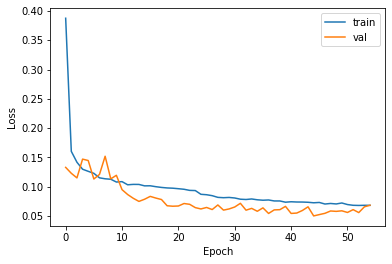

In [0]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
xc=range(len(train_loss))
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train','val'])


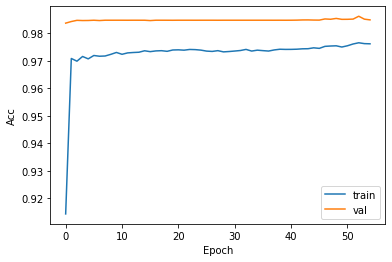

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend(['train','val'])

In [0]:
# Function to find the most probable class of an image pixel by pixel
def ClassFinder(img):
  result = np.zeros(img.shape, dtype=np.uint8)
  for r in range(len(img)):
    for c in range(len(img[0])):
      idx = np.argmax(img[r][c])
      result[r][c][idx]=1
      
  return result    

In [0]:
train_result = model.predict(TrainX, batch_size=16)
print(np.shape(train_result))
Train_predict = [ ]
for img in train_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_predict.append(encoded_img)

Predicted_images = np.asarray(Train_predict)
print(Predicted_images.shape)

dice = dc(train_result, TrainY)
pre  = precision(train_result,TrainY)
re   = recall(train_result,TrainY)
print('Train dc: '  + str(dice))
print('Train pre: ' + str(pre))
print('Train re: '  + str(re))

(2000, 240, 240, 4)
(2000, 240, 240)
Train dc: 0.4
Train pre: 0.25
Train re: 1.0


In [0]:
test_result = model.predict(TestX, batch_size=16)
print(np.shape(test_result))

Test_predict = [ ]
for img in test_result:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_predict.append(encoded_img)

Predicted_images_test = np.asarray(Test_predict)
print(Predicted_images_test.shape)

dice = dc(test_result, TestY)
pre  = precision(test_result,TestY)
re   = recall(test_result,TestY)
print('Test dc: '  + str(dice))
print('Test pre: ' + str(pre))
print('Test re: '  + str(re))

(960, 240, 240, 4)
(960, 240, 240)
Test dc: 0.4
Test pre: 0.25
Test re: 1.0


In [0]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(Actual, Predicted):
  ActualY = np.reshape(Actual,(-1, Actual.shape[3]))
  PredY = np.reshape(Predicted,(-1, Predicted.shape[3]))
  matrix = confusion_matrix(ActualY.argmax(axis = 1), PredY.argmax(axis = 1))
  return matrix

def get_precision(confusion_matrix):
  precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 0)
  nan_indices = np.isnan(precision)
  precision[nan_indices] = 0
  return precision

def get_recall(confusion_matrix):
  recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis = 1)
  nan_indices = np.isnan(recall)
  recall[nan_indices] = 0
  return recall


In [0]:
test_matrix = get_confusion_matrix(TestY, test_result)
train_matrix = get_confusion_matrix(TrainY, train_result)
print(test_matrix)
print(train_matrix)

[[27633158        0       78     5409]
 [    4209        0        0        0]
 [       0        0        0        0]
 [27630400        0     2030    20716]]
[[108236487         0     74354    686150]
 [   457810         0     40192      8521]
 [   687609         0    271875    560541]
 [   263084         0     35920   3877457]]


In [0]:
test_precision = get_precision(test_matrix)
print('Test Precision')
print(test_precision)
test_recall = get_recall(test_matrix)
print('Test Recall')
print(test_recall)
train_precision = get_precision(train_matrix)
print('Train Precision')
print(train_precision)
train_recall = get_recall(train_matrix)
print('Train Recall')
print(train_recall)

Test Precision
[0.49998687 0.         0.         0.79295694]
Test Recall
[9.99801474e-01 0.00000000e+00 0.00000000e+00 7.49137187e-04]
Train Precision
[0.98715397 0.         0.64373338 0.75544653]
Train Recall
[0.99302271 0.         0.17886219 0.92840733]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


In [0]:
weight_matrix = np.zeros((4,1))
weight_matrix[0] = 0.7
weight_matrix[1] = 0.04
weight_matrix[2] = 0.06
weight_matrix[3] = 0.2
print(weight_matrix.shape)


(4, 1)


In [0]:
def get_overall_precision(precision, weights):
  final_precision = np.dot(precision,weights)
  return final_precision

def get_overall_recall(recall, weights):
  final_recall = np.dot(recall ,weights)
  return final_recall

In [0]:
final_test_precision  = get_overall_precision(test_precision, weight_matrix)
final_test_recall     = get_overall_recall(test_recall, weight_matrix)
final_train_precision = get_overall_precision(train_precision, weight_matrix)
final_train_recall    = get_overall_recall(train_recall, weight_matrix)
print('Final Test Precision')
print(final_test_precision)
print('Final Test Recall')
print(final_test_recall)
print('Final Train Precision')
print(final_train_precision)
print('Final Train Recall')
print(final_train_recall)

Final Test Precision
[0.5085822]
Final Test Recall
[0.70001086]
Final Train Precision
[0.88072109]
Final Train Recall
[0.89152909]


In [0]:
from scipy.stats import hmean

def dice_coefficient(precision, recall):
  return hmean(np.asarray([precision , recall]))
  

In [0]:
test_dice_coeff = dice_coefficient(final_test_precision, final_test_recall)
print('Test Dice coeff')
print(test_dice_coeff)

train_dice_coeff = dice_coefficient(final_train_precision, final_train_recall)
print('Train Dice coeff')
print(train_dice_coeff)

Test Dice coeff
[0.58913637]
Train Dice coeff
[0.88609213]


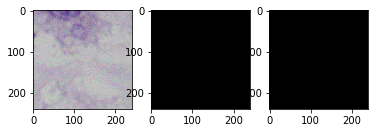

In [0]:
copy1  = np.copy(TestX [780])
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
copy3 = np.reshape(copy2,(240, 240,3))
Img = cv2.cvtColor(copy3,cv2.COLOR_BGR2RGB)

Mask = TestGroundTruth[240]

Predicted_Mask = Predicted_images_test[240] 

plt.subplot(131).imshow(Img)
plt.subplot(132).imshow(Mask,'gray')
plt.subplot(133).imshow(Predicted_Mask,'gray')

In [0]:
def stitchMaskPatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240] = pieces[k]
      k = k + 1
  return reconstructed_img


def stitchImagePatches(pieces):
  k = 0
  reconstructed_img = np.ones([1440,1920,3])
  for r in range(6):
    row = r * 240
    for c in range(8):
      col = c * 240
      reconstructed_img[row:row+240,col:col+240,:] = pieces[k]
      k = k + 1
  return reconstructed_img


(48, 240, 240, 4)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0. 170. 255.]


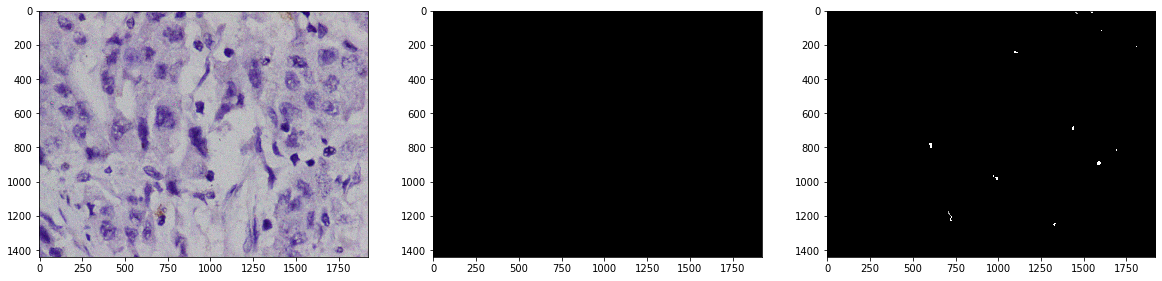

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 12   # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TestX[id:id+48]

Mask_input = TestY[id:id+48]
Test_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Test_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Test_Actual)
print(Mask_input.shape)

final_output = Predicted_images_test[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')



(48, 240, 240, 4)
(48, 240, 240)
(1440, 1920, 3)
(1440, 1920)
(1440, 1920)
[  0. 170. 255.]


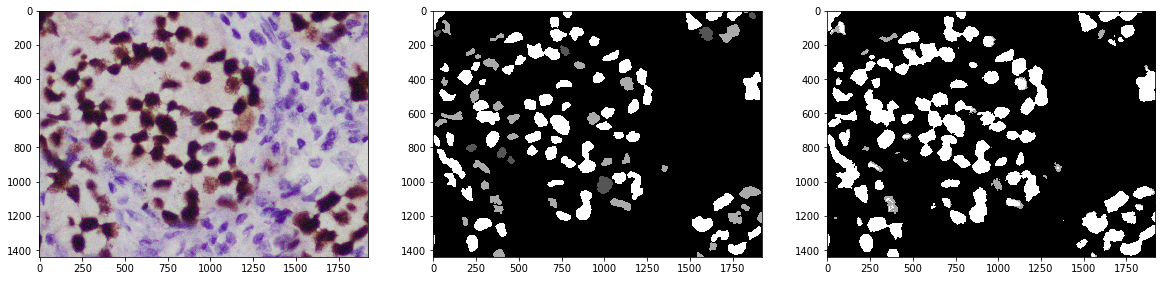

In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20,20))
id = 2   # enter between 0- 40 since there are 4 patients with 10 images each

id = id * 48
final_input = TrainX[id:id+48]

Mask_input = TrainY[id:id+48]
Train_Actual = [ ]
for img in Mask_input:
  img = ClassFinder(img)
  encoded_img = convertFromOneHot(img)
  Train_Actual.append(encoded_img)
  
print(Mask_input.shape)
Mask_input = np.asarray(Train_Actual)
print(Mask_input.shape)

final_output = Predicted_images[id:id+48]

final_input = stitchImagePatches(final_input)
Mask_input =  stitchMaskPatches(Mask_input)
final_output = stitchMaskPatches(final_output)

print(final_input.shape)
print(final_output.shape)
print(Mask_input.shape)

print(np.unique(final_output))
copy1  = np.copy(final_input)
copy2 = copy1.astype('float32')*255
copy2 = copy2.astype('uint8')
final_input = np.reshape(copy2,(1440, 1920,3))
final_input = cv2.cvtColor(final_input,cv2.COLOR_BGR2RGB)

plt.subplot(131).imshow(final_input)
plt.subplot(132).imshow(Mask_input,'gray')
plt.subplot(133).imshow(final_output,'gray')